In [460]:
import pandas as pd
import adata

etfs = ['561300', '159726', '515100', '513500', '511260', '518880', '164824'] 

df = pd.DataFrame()

for i in etfs:
    etf_df = adata.fund.market.get_market_etf(i, start_date='2018-01', end_date='2024-12-23', k_type=1)
    etf_df['close'] = etf_df['close'].astype(float)
    pivot_df = etf_df.pivot(index='trade_date', columns='fund_code', values='close')
    df = pd.concat([df, pivot_df], axis=1)

change_df = df.pct_change().dropna()
change_df

/tmp/ipykernel_192627/2982888194.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  change_df = df.pct_change().dropna()


fund_code,561300,159726,515100,513500,511260,518880,164824
trade_date,,,,,,,
2021-12-13,0.008073,-0.004012,-0.002964,0.011372,-0.001437,0.005610,0.003331
2021-12-14,-0.005005,-0.024169,-0.002973,-0.011947,0.002593,0.000837,-0.013278
2021-12-15,-0.012072,0.000000,0.000994,-0.004979,-0.000623,-0.010033,-0.010934
2021-12-16,0.005092,0.005160,0.012910,0.020729,-0.000563,0.009009,0.005952
2021-12-17,-0.015198,0.001027,-0.000980,-0.016807,0.001022,0.012556,-0.016906
...,...,...,...,...,...,...,...
2020-06-24,0.000000,0.000000,0.000000,0.002904,0.004594,0.007213,0.009581
2020-06-29,0.000000,0.000000,0.000000,-0.031853,0.000412,0.000000,-0.023725
2020-06-30,0.000000,0.000000,0.000000,0.003988,-0.000923,0.001023,0.009721


In [404]:
import numpy as np
from arch import arch_model
from scipy.optimize import minimize


def forecast_volatility(returns, p=1, q=1, horizon=3):
    model = arch_model(returns, vol='GARCH', p=p, q=q, rescale=False)
    results = model.fit(disp='off')
    forecast = results.forecast(horizon=horizon)
    monthly_vol = np.sqrt(forecast.variance.iloc[-1].mean())
    return (monthly_vol * np.sqrt(12)) # 年化月度波动率

def objective(weights, vol_pred, corr_matrix, target_vol):
    # 计算协方差矩阵
    cov_matrix = np.diag(vol_pred) @ corr_matrix @ np.diag(vol_pred)
    # 计算组合波动率
    portfolio_vol = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))
    return np.abs(portfolio_vol - target_vol)

def constraint(weights):
    return np.sum(weights) - 1

def optimize_weights(vol_pred, corr_matrix, target_vol, min_weight=0.05):
    n_assets = len(vol_pred)
    initial_weights = np.array([1/n_assets] * n_assets)
    bounds = tuple((min_weight, 1) for _ in range(n_assets))
    constraints = ({'type': 'eq', 'fun': constraint})
    result = minimize(objective, initial_weights, args=(vol_pred, corr_matrix, target_vol), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def target_volatility_strategy(returns, target_vol, min_weight=0.05, lookback=60):
    n_assets = returns.shape[1]
    weights = np.zeros((len(returns), n_assets))
    
    # 创建一个日期索引
    dates = returns.index
    
    for t in range(lookback, len(returns)):
        historical_returns = returns.iloc[t-lookback:t]
        vol_pred = np.array([forecast_volatility(historical_returns[col]) for col in historical_returns.columns])
        corr_matrix = historical_returns.corr()
        optimized_weights = optimize_weights(vol_pred, corr_matrix, target_vol, min_weight)
        weights[t] = optimized_weights
    
    # 创建一个 DataFrame，索引为日期，列名为资产名称
    weights_df = pd.DataFrame(weights[lookback:], index=dates[lookback:], columns=returns.columns)
    # 保留小数点后两位
    weights_df = weights_df.round(2)
    
    strategy_returns = (weights_df * returns.iloc[lookback:]).sum(axis=1)
    
    return strategy_returns, weights_df

def equal_weight_strategy(returns):
    n_assets = returns.shape[1]
    weights = np.ones((len(returns), n_assets)) * (1 / n_assets)  # 等权重分配
    
    # 创建一个日期索引
    dates = returns.index
    
    # 创建一个 DataFrame，索引为日期，列名为资产名称
    weights_df = pd.DataFrame(weights, index=dates, columns=returns.columns)
    
    # 计算策略收益
    strategy_returns = (weights_df * returns).sum(axis=1)
    
    return strategy_returns, weights_df


def performance_metrics(returns):
    """Calculates and prints performance metrics."""
    total_return = (returns + 1).prod() - 1
    annualized_return = (1 + total_return)**(252/len(returns)) - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = ((returns + 1).cumprod().div((returns + 1).cumprod().cummax()) - 1).min()

    print(f"Total Return: {total_return:.4f}")
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Volatility: {annualized_volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.4f}")

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


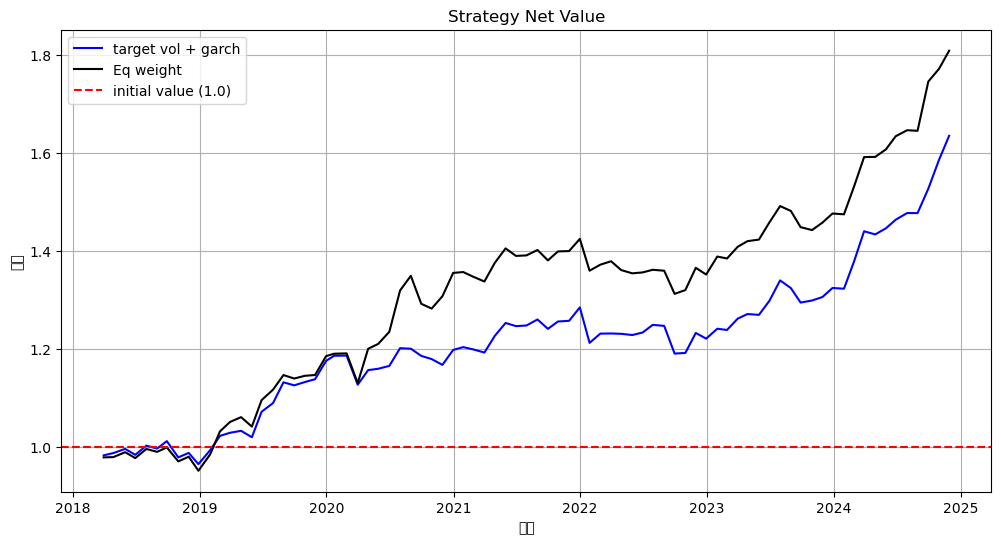

目标波动率-指标
Total Return: 0.6348
Annualized Return: 3.6146
Annualized Volatility: 0.3199
Sharpe Ratio: 11.2985
Max Drawdown: -0.0734


None

等权-指标
Total Return: 0.8085
Annualized Return: 5.3180
Annualized Volatility: 0.3610
Sharpe Ratio: 14.7326
Max Drawdown: -0.0788


In [446]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算净值
initial_value = 1.0  # 初始净值
net_value = (1 + strategy_returns).cumprod() * initial_value
net_value.index = pd.to_datetime(net_value.index)


initial_value = 1.0  # 初始净值
eq_net_value = (1 + eq_strategy_returns).cumprod() * initial_value
eq_net_value.index = pd.to_datetime(eq_net_value.index)

start_date = max(net_value.index[0], eq_net_value.index[0])
net_value = net_value[net_value.index >= start_date]
eq_net_value = eq_net_value[eq_net_value.index >= start_date]

# 绘制净值曲线
plt.figure(figsize=(12, 6))
plt.plot(net_value.index, net_value, label='target vol + garch', color='blue')
plt.plot(eq_net_value.index, eq_net_value, label='Eq weight', color='black')
plt.title('Strategy Net Value')
plt.xlabel('日期')
plt.ylabel('净值')
plt.axhline(y=1, color='r', linestyle='--', label='initial value (1.0)')
plt.legend()
plt.grid()
plt.show()

print("目标波动率-指标")
display(performance_metrics(strategy_returns))

print("等权-指标")
performance_metrics(eq_strategy_returns)

fund_code   561300  159726  515100  513500   511260  518880  164824
trade_date                                                         
2018-01-02     NaN     NaN     NaN   0.814   98.200   2.723     NaN
2018-01-03     NaN     NaN     NaN   0.818   98.160   2.733     NaN
2018-01-04     NaN     NaN     NaN   0.819   98.161   2.719     NaN
2018-01-05     NaN     NaN     NaN   0.820   98.078   2.728     NaN
2018-01-08     NaN     NaN     NaN   0.826   97.986   2.730     NaN
...            ...     ...     ...     ...      ...     ...     ...
2024-12-17   0.823   1.035   1.490   2.254  135.107   5.940   1.562
2024-12-18   0.827   1.048   1.496   2.229  134.821   5.932   1.559
2024-12-19   0.826   1.046   1.482   2.157  134.687   5.885   1.530
2024-12-20   0.823   1.040   1.477   2.144  135.320   5.892   1.525
2024-12-23   0.824   1.047   1.476   2.194  135.499   5.951   1.535

[1693 rows x 7 columns]


/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/tmp/ipykernel_192627/1095111623.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return prices.pct_change().dropna()
/tmp/ipykernel_192627/1095111623.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return prices.pct_change().dropna()
/tmp/ipykernel_192627/1095111623.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Ei

Net Value Over Time:
 trade_date
2022-01-04    1.010248
2022-01-05    1.007262
2022-01-06    1.008244
2022-01-07    1.011675
2022-01-10    1.015326
                ...   
2024-12-17    1.220304
2024-12-18    1.218819
2024-12-19    1.213244
2024-12-20    1.215840
2024-12-23    1.220101
Length: 720, dtype: float64


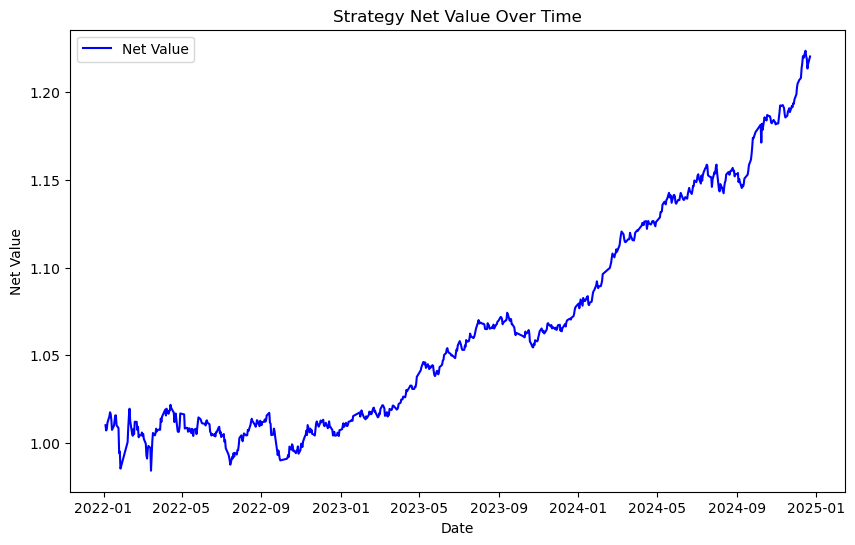

Total Return: 0.2201
Annualized Return: 0.0721
Annualized Volatility: 0.0404
Sharpe Ratio: 1.7862
Max Drawdown: -0.0346


In [466]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 获取历史价格数据（假设你已经有了这个DataFrame）
# df = get_historical_prices(tickers, start_date, end_date)

def calculate_returns(prices):
    return prices.pct_change().dropna()

def fit_garch_model(returns, p=1, q=1):
    """Fit a GARCH(p, q) model to the returns and predict volatility."""
    garch = arch_model(returns, vol='Garch', p=p, q=q, rescale=False)
    res = garch.fit(disp='off')
    forecast = res.forecast(horizon=1)
    return forecast.variance.iloc[-1].values[0] ** 0.5  # 返回下一个时期的预测波动率

def cvar_optimization(returns, alpha=0.05):
    n_assets = returns.shape[1]
    initial_weights = np.ones(n_assets) / n_assets
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
    bounds = [(0.05, 1) for _ in range(n_assets)]
    
    def cvar_objective(weights):
        portfolio_returns = returns @ weights
        VaR = np.percentile(portfolio_returns, 100 * alpha)
        exceedances = portfolio_returns[portfolio_returns < VaR]
        if len(exceedances) > 0:
            CVaR = -np.mean(exceedances)
        else:
            CVaR = -VaR
        return CVaR
    
    result = minimize(cvar_objective, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
    return pd.Series(result.x, index=returns.columns)

def backtest_strategy(df, window_size=200, period=20, alpha=0.05):
    # 提取月度数据点
    p_df = df.iloc[::-period].iloc[::-1].dropna()
    
    all_daily_returns = []  # 保存所有窗口的每日回报
    weights_list = []  # 保存每期的权重
    vol_forecasts = []  # 保存每个窗口的波动率预测
    
    start_at = max(0, len(p_df) - len(df) // window_size)
    for i in range(start_at, len(p_df) - 1):
        current_date = p_df.index[i]
        
        # 获取过去window_size天的收益率数据
        start_idx = df.index.get_loc(current_date) - window_size + 1
        if start_idx < 0:
            continue
        
        historical_data = df.iloc[start_idx:start_idx + window_size]
        returns = calculate_returns(historical_data)
        
        # 进行CVaR组合优化
        weights = cvar_optimization(returns, alpha=alpha)
        weights = weights.round(2)
        weights_list.append(weights)  # 保存权重
        
        # 计算下一个period天的策略回报
        if (i + 1) > len(p_df):
            break
        next_date = p_df.index[i + 1]
        next_period_data = df.loc[current_date:next_date]
        next_period_returns = calculate_returns(next_period_data)
        
        if not next_period_returns.empty:
            daily_returns = (weights * next_period_returns).sum(axis=1)
            all_daily_returns.append(daily_returns)
            
    # 一次性计算净值
    all_daily_returns_df = pd.concat(all_daily_returns)
    net_value_series = (1 + all_daily_returns_df).cumprod()
    weight_df = pd.DataFrame(weights_list, columns=df.columns)
    
    return net_value_series, all_daily_returns_df, weight_df

e_df = df.copy()
e_df.index = pd.to_datetime(e_df.index)
e_df = e_df.sort_index()

    # 回测策略
net_value, all_daily_returns_df, weight_df = backtest_strategy(e_df, window_size=60, period=30, alpha=0.2)
# 打印结果
print("Net Value Over Time:\n", net_value)
# 绘制净值曲线
plt.figure(figsize=(10, 6))
plt.plot(net_value, label='Net Value', color='blue')
plt.title('Strategy Net Value Over Time')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.show()

performance_metrics(all_daily_returns_df)

Net Value Over Time:
 trade_date
2024-01-24    0.978279
2024-01-25    0.939912
2024-01-26    0.937909
2024-01-29    0.963881
2024-01-30    0.988235
                ...   
2024-12-17    1.078091
2024-12-18    1.074789
2024-12-19    1.057778
2024-12-20    1.054738
2024-12-23    1.067631
Length: 220, dtype: float64


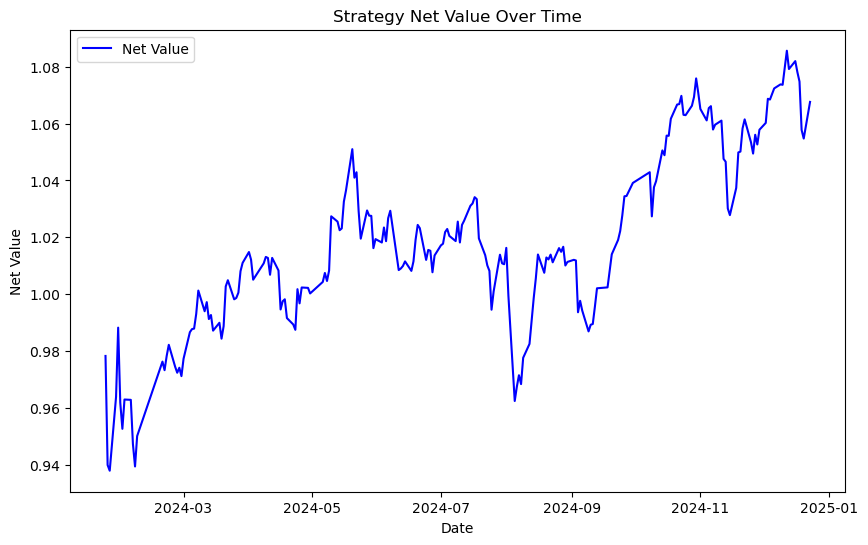

Total Return: 0.0676
Annualized Return: 0.0778
Annualized Volatility: 0.1323
Sharpe Ratio: 0.5885
Max Drawdown: -0.0843


In [467]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_returns(prices):
    return prices.pct_change().dropna()

def portfolio_return(weights, returns):
    """Calculates portfolio return."""
    return np.sum(returns.mean() * weights)

def calculate_cvar(returns, confidence_level=0.05): #alpha=0.05
    """Calculates Conditional Value at Risk (CVaR)."""
    sorted_returns = np.sort(returns)
    alpha_index = int(np.floor((1 - confidence_level) * len(returns)))
    cvar = -np.mean(sorted_returns[:alpha_index])
    return cvar

def portfolio_cvar(weights, returns, confidence_level=0.05):
    """Calculates portfolio CVaR."""
    portfolio_returns = returns.dot(weights)
    return calculate_cvar(portfolio_returns, confidence_level)

def mean_cvar_optimization(returns, target_vol=0.05, confidence_level=0.05):
    """Optimizes portfolio for Mean-CVaR given a target volatility (used as a proxy to constrain risk)."""
    num_assets = returns.shape[1]
    args = (returns, confidence_level)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, # Weights sum to 1
                   {'type': 'ineq', 'fun': lambda weights: target_vol - np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))}) # Volatility constraint (less than or equal to target)
    bounds = tuple((0.05, 1) for asset in range(num_assets))  # Weights between 0.05 and 1
    initial_weights = np.array([1/num_assets]*num_assets)
    result = minimize(portfolio_cvar, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return pd.Series(result.x, index=returns.columns)

def backtest_strategy(df, window_size=200, period=20, target_vol=0.05, confidence_level=0.05):
    p_df = df.iloc[::-period].iloc[::-1].dropna()
    all_daily_returns = []
    weights_list = []

    start_at = max(0, len(p_df) - len(df) // window_size)
    for i in range(start_at, len(p_df) - 1):
        current_date = p_df.index[i]
        start_idx = df.index.get_loc(current_date) - window_size + 1
        if start_idx < 0:
            continue
            
        historical_data = df.iloc[start_idx:start_idx + window_size]
        returns = calculate_returns(historical_data)

        weights = mean_cvar_optimization(returns, target_vol=target_vol, confidence_level=confidence_level)
        weights = weights.round(2)
        weights_list.append(weights)

        if (i + 1) > len(p_df):
            break
        next_date = p_df.index[i + 1]
        next_period_data = df.loc[current_date:next_date]
        next_period_returns = calculate_returns(next_period_data)
        
        if not next_period_returns.empty:
            daily_returns = (weights * next_period_returns).sum(axis=1)
            all_daily_returns.append(daily_returns)
            
    all_daily_returns_df = pd.concat(all_daily_returns)
    net_value_series = (1 + all_daily_returns_df).cumprod()
    weight_df = pd.DataFrame(weights_list, columns=df.columns)
    
    return net_value_series, all_daily_returns_df, weight_df

# Example usage (replace with your actual data 'df' and import performance_metrics)
# Assuming 'df' is your price DataFrame with DateTimeIndex
e_df = df.copy()
e_df.index = pd.to_datetime(e_df.index)
e_df = e_df.sort_index()

net_value, all_daily_returns_df, weight_df = backtest_strategy(e_df.dropna(), window_size=60, period=20, target_vol=0.05, confidence_level=0.05)

print("Net Value Over Time:\n", net_value)

plt.figure(figsize=(10, 6))
plt.plot(net_value, label='Net Value', color='blue')
plt.title('Strategy Net Value Over Time')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.show()

performance_metrics(all_daily_returns_df) # Make sure you have this function defined elsewhere.

Net Value Over Time:
 trade_date
2023-08-14    0.999679
2023-08-15    1.002351
2023-08-16    1.001040
2023-08-17    1.000920
2023-08-18    0.998238
                ...   
2024-12-17    1.331345
2024-12-18    1.329506
2024-12-19    1.315244
2024-12-20    1.314824
2024-12-23    1.321846
Length: 330, dtype: float64


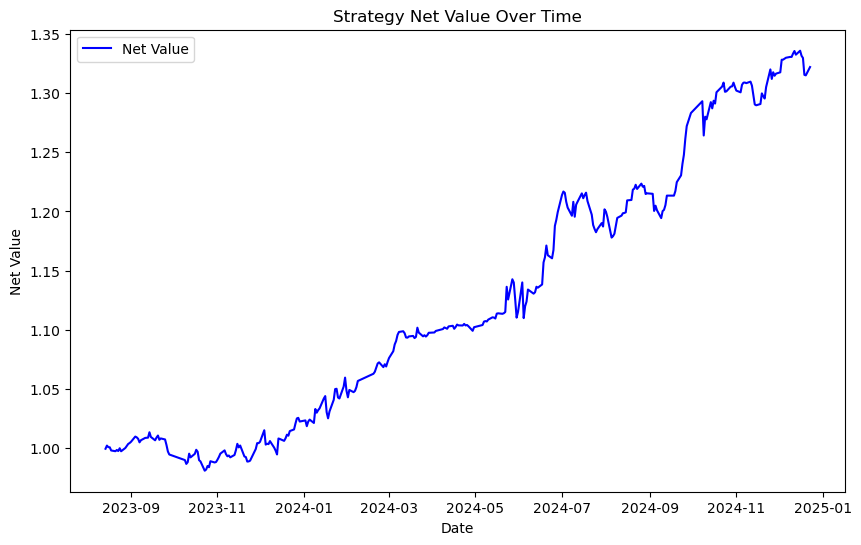

Total Return: 0.3218
Annualized Return: 0.2375
Annualized Volatility: 0.0857
Sharpe Ratio: 2.7703
Max Drawdown: -0.0320


In [489]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_returns(prices):
    return prices.pct_change().dropna()

def portfolio_return(weights, returns):
    """Calculates portfolio return."""
    return np.sum(returns.mean() * weights)

def calculate_cvar(returns, confidence_level=0.05):
    """Calculates Conditional Value at Risk (CVaR)."""
    sorted_returns = np.sort(returns)
    alpha_index = int(np.floor((1 - confidence_level) * len(returns)))
    cvar = -np.mean(sorted_returns[:alpha_index])
    return cvar

def portfolio_cvar(weights, returns, confidence_level=0.05):
    """Calculates portfolio CVaR."""
    portfolio_returns = returns.dot(weights)
    return calculate_cvar(portfolio_returns, confidence_level)

def mean_cvar_optimization(returns, target_return, confidence_level=0.05):
    """Optimizes portfolio for Mean-CVaR given a target return."""
    num_assets = returns.shape[1]
    args = (returns, confidence_level)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, # Weights sum to 1
                   {'type': 'eq', 'fun': lambda x: portfolio_return(x, returns) - target_return}) #Target Return constraint
    bounds = tuple((0.03, 1) for asset in range(num_assets))  # Weights between 0.05 and 1
    initial_weights = np.array([1/num_assets]*num_assets)
    result = minimize(portfolio_cvar, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return pd.Series(result.x, index=returns.columns)

def backtest_strategy(df, window_size=200, period=20, target_return_annualized=0.10, confidence_level=0.05):
    """Backtests the Mean-CVaR strategy with a target return."""

    p_df = df.iloc[::-period].iloc[::-1].dropna()
    all_daily_returns = []
    weights_list = []

    start_at = max(0, len(p_df) - len(df) // window_size)
    for i in range(start_at, len(p_df)):
        current_date = p_df.index[i]
        start_idx = df.index.get_loc(current_date) - window_size + 1
        if start_idx < 0:
            continue
        
        historical_data = df.iloc[start_idx:start_idx + window_size]
        returns = calculate_returns(historical_data)

        # Convert annualized target return to daily target return
        trading_days_per_year = 252 # Adjust if needed
        target_return_daily = (1 + target_return_annualized)**(1/trading_days_per_year) - 1
        
        weights = mean_cvar_optimization(returns, target_return=target_return_daily, confidence_level=confidence_level)
        weights = weights.round(2)
        weights_list.append(pd.Series(weights, name=current_date, index=returns.columns))

        if (i + 1) > (len(p_df) - 1):
            break
        next_date = p_df.index[i + 1]
        next_period_data = df.loc[current_date:next_date]
        next_period_returns = calculate_returns(next_period_data)
        
        if not next_period_returns.empty:
            daily_returns = (weights * next_period_returns).sum(axis=1)
            all_daily_returns.append(daily_returns)
            
    all_daily_returns_df = pd.concat(all_daily_returns)
    net_value_series = (1 + all_daily_returns_df).cumprod()
    weight_df = pd.concat(weights_list, axis=1)
    
    return net_value_series, all_daily_returns_df, weight_df

# Example usage (replace with your actual data 'df' and import performance_metrics)
# Assuming 'df' is your price DataFrame with DateTimeIndex
e_df = df.copy()
e_df.index = pd.to_datetime(e_df.index)
e_df = e_df.sort_index()

net_value, all_daily_returns_df, weight_df = backtest_strategy(e_df.dropna(), window_size=60, period=30, target_return_annualized=0.08, confidence_level=0.05)

print("Net Value Over Time:\n", net_value)

plt.figure(figsize=(10, 6))
plt.plot(net_value, label='Net Value', color='blue')
plt.title('Strategy Net Value Over Time')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.show()

performance_metrics(all_daily_returns_df) # Make sure you have this function defined elsewhere.

In [490]:
weight_df.T.tail(2)

fund_code,561300,159726,515100,513500,511260,518880,164824
2024-11-11,0.03,0.03,0.03,0.03,0.33,0.11,0.44
2024-12-23,0.05,0.03,0.03,0.03,0.30,0.26,0.31


In [ ]:
def portfolio_volatility(weights, returns):
    """Calculates the annualized volatility of a portfolio."""
    cov_matrix = returns.cov()
    portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_vol = np.sqrt(portfolio_var) * np.sqrt(252)  # Annualize the volatility
    return portfolio_vol

def max_return_given_volatility(returns, target_volatility):
    """Optimizes portfolio for maximum return given a target volatility."""
    num_assets = returns.shape[1]
    args = (returns,)
    
    # Define the objective function to maximize (negative for minimization)
    def neg_portfolio_return(weights, returns):
        return -portfolio_return(weights, returns)
    
    # Constraint for target volatility
    vol_constraint = {'type': 'eq', 
                      'fun': lambda x: portfolio_volatility(x, returns) - target_volatility}
    
    # Weights sum to 1 constraint
    sum_constraint = {'type': 'eq', 
                      'fun': lambda x: np.sum(x) - 1}
    
    # Bounds for each asset weight
    bounds = tuple((0.03, 1) for asset in range(num_assets))  # Weights between 0.03 and 1
    
    # Initial guess for weights
    initial_weights = np.array([1/num_assets]*num_assets)
    
    # Optimization
    result = minimize(neg_portfolio_return, initial_weights, args=args, method='SLSQP', 
                      bounds=bounds, constraints=[sum_constraint, vol_constraint])
    
    # Return optimized weights as a Series
    return pd.Series(result.x, index=returns.columns)

def backtest_strategy(df, window_size=200, period=20, target_volatility_annualized=0.15):
    """Backtests the strategy with a target volatility."""
    
    p_df = df.iloc[::-period].iloc[::-1].dropna()
    all_daily_returns = []
    weights_list = []

    start_at = max(0, len(p_df) - len(df) // window_size)
    for i in range(start_at, len(p_df)):
        current_date = p_df.index[i]
        start_idx = df.index.get_loc(current_date) - window_size + 1
        if start_idx < 0:
            continue
        
        historical_data = df.iloc[start_idx:start_idx + window_size]
        returns = calculate_returns(historical_data)

        # Convert annualized target volatility to daily target volatility
        trading_days_per_year = 252  # Adjust if needed
        target_volatility_daily = target_volatility_annualized / np.sqrt(trading_days_per_year)
        
        weights = max_return_given_volatility(returns, target_volatility_daily)
        weights = weights.round(2)
        weights_list.append(pd.Series(weights, name=current_date, index=returns.columns))

        if (i + 1) > (len(p_df) - 1):
            break
        next_date = p_df.index[i + 1]
        next_period_data = df.loc[current_date:next_date]
        next_period_returns = calculate_returns(next_period_data)
        
        if not next_period_returns.empty:
            daily_returns = (weights * next_period_returns).sum(axis=1)
            all_daily_returns.append(daily_returns)
            
    all_daily_returns_df = pd.concat(all_daily_returns)
    net_value_series = (1 + all_daily_returns_df).cumprod()
    weight_df = pd.concat(weights_list, axis=1)
    
    return net_value_series, all_daily_returns_df, weight_df

# Example usage (replace with your actual data 'df' and import performance_metrics)
# Assuming 'df' is your price DataFrame with DateTimeIndex
e_df = df.copy()
e_df.index = pd.to_datetime(e_df.index)
e_df = e_df.sort_index()

net_value, all_daily_returns_df, weight_df = backtest_strategy(
    e_df.dropna(), 
    window_size=60, 
    period=30, 
    target_volatility_annualized=0.1  # Target annualized volatility
)

print("Net Value Over Time:\n", net_value)

plt.figure(figsize=(10, 6))
plt.plot(net_value, label='Net Value', color='blue')
plt.title('Strategy Net Value Over Time')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.show()

performance_metrics(all_daily_returns_df)  # Make sure you have this function defined elsewhere.

In [ ]:
weight_df.T.tail(2)